## Prompt:  

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model thatcan predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. Keep in mind classification metrics when evaluating the performance of your model!

`loan_status` is our label

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import max_norm

%matplotlib inline

In [2]:
# Load information relating to the features of our dataset
info_df = pd.read_csv('../../data/lending_club_info.csv', index_col='LoanStatNew')

In [3]:
info_df

,Description
LoanStatNew,
loan_amnt,The listed amount of the loan applied for by t...
term,The number of payments on the loan. Values are...
int_rate,Interest Rate on the loan
installment,The monthly payment owed by the borrower if th...
grade,LC assigned loan grade
sub_grade,LC assigned loan subgrade
emp_title,The job title supplied by the Borrower when ap...
emp_length,Employment length in years. Possible values ar...
home_ownership,The home ownership status provided by the borr...


In [4]:
print(info_df.loc['revol_util']['Description'])

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


In [5]:
def feat_info(col_name):
    print(info_df.loc[col_name]['Description'])

In [6]:
feat_info('grade')

LC assigned loan grade


## Load and Set-Up Data

In [7]:
df = pd.read_csv('../../data/lending_club_loan_two.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

## EDA  

### Investigate Target (`loan_status`)  

Look at the balance of the classes

<AxesSubplot:xlabel='loan_status', ylabel='count'>

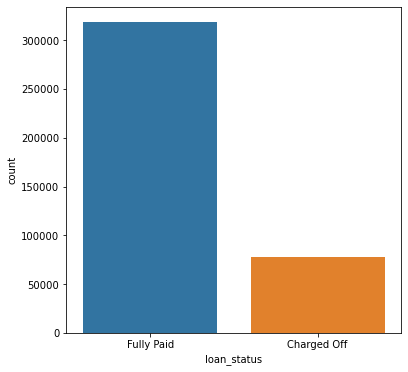

In [9]:
plt.figure(figsize=(6,6))
sns.countplot(x='loan_status', data=df)

We can expect our model to do well in terms of accuracy, so precision and recall will be our areas of evaluation.

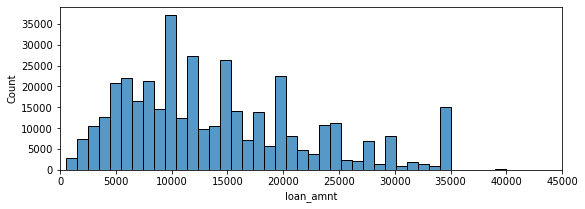

In [10]:
plt.figure(figsize=(9,3))
sns.histplot(df['loan_amnt'], kde=False, bins=40)
plt.xlim(0,45000);

### Correlation

In [11]:
df.corr()['loan_amnt'].sort_values()

pub_rec_bankruptcies   -0.106539
pub_rec                -0.077779
dti                     0.016636
revol_util              0.099911
int_rate                0.168921
open_acc                0.198556
mort_acc                0.222315
total_acc               0.223886
revol_bal               0.328320
annual_inc              0.336887
installment             0.953929
loan_amnt               1.000000
Name: loan_amnt, dtype: float64

In [12]:
df.corr()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


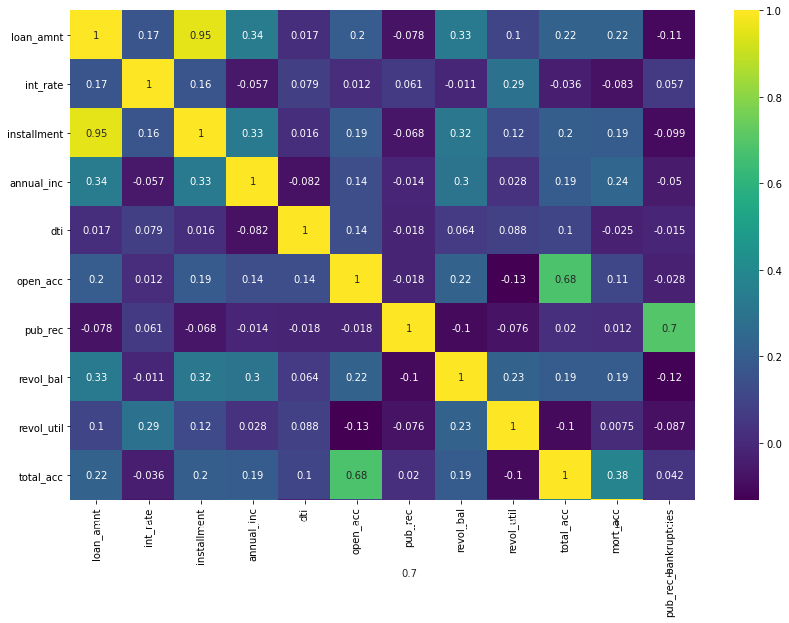

In [13]:
plt.figure(figsize=(14,9))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.ylim(10,0);

Our target has a near-perfect correlation with `installment`, let's look into that.  We want to make sure there is not a feature which will perfectly predict our label. A case like that is often duplicate information or data leakage.

In [14]:
# What are the two features?
feat_info('installment')

The monthly payment owed by the borrower if the loan originates.


In [15]:
feat_info('loan_amnt')

The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


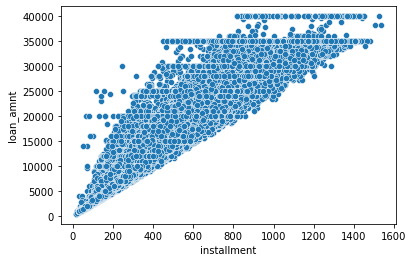

In [16]:
sns.scatterplot(x='installment', y='loan_amnt', data=df);

This make sense because the company probably has some formula to calculate a client's available installment plans based on how much is being lent.

<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

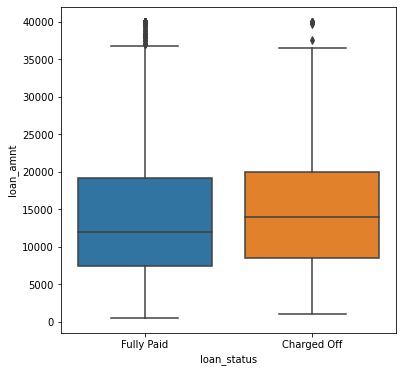

In [17]:
plt.figure(figsize=(6,6))
sns.boxplot(x='loan_status', y='loan_amnt', data=df)

In [18]:
# The qunatitative data for the box plot
df.groupby('loan_status')['loan_amnt'].describe().transpose()

loan_status,Charged Off,Fully Paid
count,77673.000000,318357.000000
mean,15126.300967,13866.878771
std,8505.090557,8302.319699
min,1000.000000,500.000000
25%,8525.000000,7500.000000
50%,14000.000000,12000.000000
75%,20000.000000,19225.000000
max,40000.000000,40000.000000


It make sense because more expensive loans are harder to pay off.

In [19]:
# Let's explore more features

print(sorted(df['grade'].unique()))
print(sorted(df['sub_grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']
['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


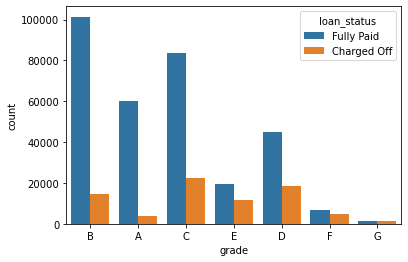

In [20]:
sns.countplot(x='grade', data=df, hue='loan_status');

Looks like higher-rated customers were way more likely to pay off their loan.

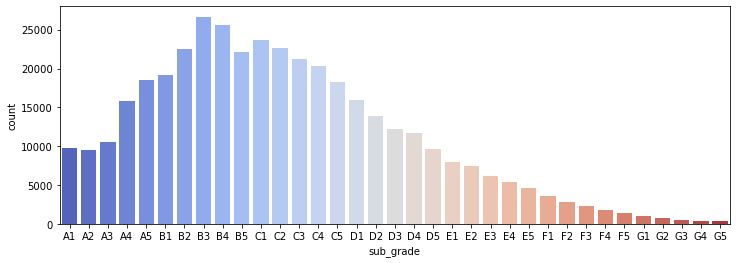

In [21]:
plt.figure(figsize=(12,4))
subgrade_order = sorted(df['sub_grade'].unique())  # take from above
sns.countplot(x='sub_grade', data=df, 
                order=subgrade_order, palette='coolwarm');

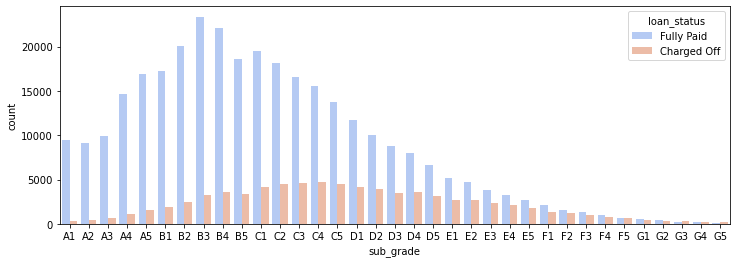

In [22]:
plt.figure(figsize=(12,4))
subgrade_order = sorted(df['sub_grade'].unique())  # take from above
sns.countplot(x='sub_grade', data=df, hue='loan_status',
                order=subgrade_order, palette='coolwarm');

Grades `F` and `G` are on the low end of getting paid, let's look into that

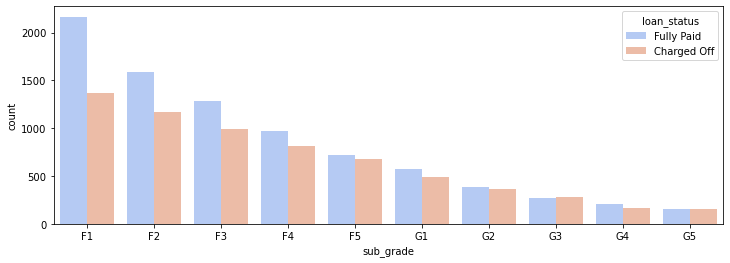

In [23]:
f_and_g_df = df[(df['grade']=='F') | (df['grade']=='G')]

plt.figure(figsize=(12,4))
subgrade_order = sorted(f_and_g_df['sub_grade'].unique())  # take from above
sns.countplot(x='sub_grade', data=f_and_g_df, hue='loan_status',
                order=subgrade_order, palette='coolwarm');

### remap loan status as paid or not

In [24]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [25]:
df['loan_repaid'] = df['loan_status'].map(
                                        {'Fully Paid': 1,
                                        'Charged Off':0})

In [26]:
# Check correctness
df[['loan_repaid', 'loan_status']]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
...,...,...
396025,1,Fully Paid
396026,1,Fully Paid
396027,1,Fully Paid
396028,1,Fully Paid


Let's look at the correlation related to the new `loan_repaid` column

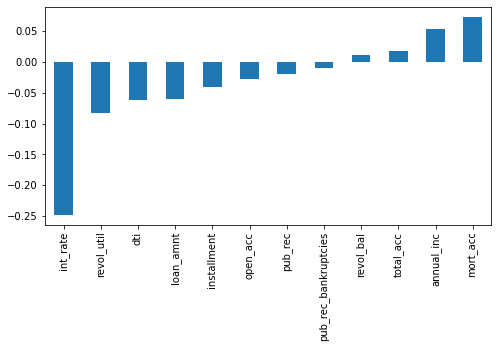

In [27]:
plt.figure(figsize=(8,4))
df.corr()['loan_repaid'].sort_values().drop('loan_repaid').plot(kind='bar');

## Data Preprocessing

### Deal with missing data, remove features, dummy-ize.

In [28]:
df.shape

(396030, 28)

In [29]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [30]:
# Percentage of missing values
100 * df.isnull().sum() / df.shape[0]

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

In [31]:
feat_info('emp_title')
print('\n')
feat_info('emp_length')

The job title supplied by the Borrower when applying for the loan.*


Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


In [32]:
# Okay, how many unique titles are there?
df['emp_title'].value_counts()

Teacher                      4389
Manager                      4250
Registered Nurse             1856
RN                           1846
Supervisor                   1830
                             ... 
Database engineer               1
Nicholls State University       1
Sartain Fischbein               1
Dollar Car Rental               1
PST/ 911 ispatcher              1
Name: emp_title, Length: 173105, dtype: int64

When it comes time to drop or fill in, we should drop this feature. There are too many different values to dummy-ize. Also, if almost half of the people have different titles, it doesn't seem like a very good descriptor. 

In [33]:
df = df.drop('emp_title', axis=1)

In [34]:
sorted(df['emp_length'].dropna().unique())

['1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year']

In [35]:
# reorder for plotting purposes
emp_length_order = [ '<1 year',
                      '1 year',
                     '2 years',
                     '3 years',
                     '4 years',
                     '5 years',
                     '6 years',
                     '7 years',
                     '8 years',
                     '9 years',
                     '10+ years']

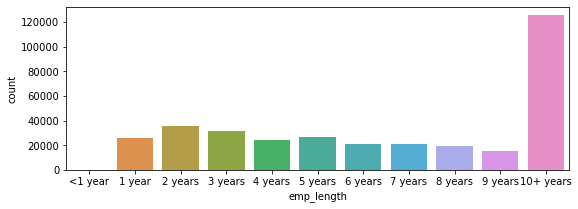

In [36]:
plt.figure(figsize=(9,3))
sns.countplot(x='emp_length', data=df, order=emp_length_order);

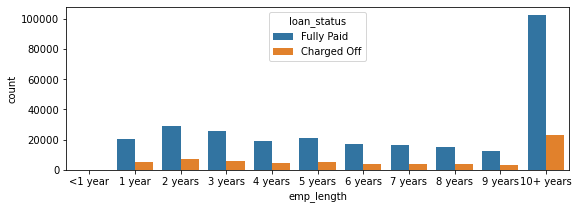

In [37]:
plt.figure(figsize=(9,3))
sns.countplot(x='emp_length', data=df, order=emp_length_order,
                hue='loan_status');

If the ratios between `Fully Paid` and `Charged Off` are nearly the same across the categories, it is not a very informative feature.

In [38]:
# employees - Fully Paid
emp_fp = df[df['loan_status']=='Fully Paid'].groupby(
            'emp_length').count()['loan_status']

emp_fp

emp_length
1 year        20728
10+ years    102826
2 years       28903
3 years       25483
4 years       19344
5 years       21403
6 years       16898
7 years       16764
8 years       15339
9 years       12244
< 1 year      25162
Name: loan_status, dtype: int64

In [39]:
# employees - Charged Off
emp_co = df[df['loan_status']=='Charged Off'].groupby(
            'emp_length').count()['loan_status']

emp_co

emp_length
1 year        5154
10+ years    23215
2 years       6924
3 years       6182
4 years       4608
5 years       5092
6 years       3943
7 years       4055
8 years       3829
9 years       3070
< 1 year      6563
Name: loan_status, dtype: int64

In [40]:
emp_co_fp_ratio = emp_co/emp_fp
emp_co_fp_ratio

emp_length
1 year       0.248649
10+ years    0.225770
2 years      0.239560
3 years      0.242593
4 years      0.238213
5 years      0.237911
6 years      0.233341
7 years      0.241887
8 years      0.249625
9 years      0.250735
< 1 year     0.260830
Name: loan_status, dtype: float64

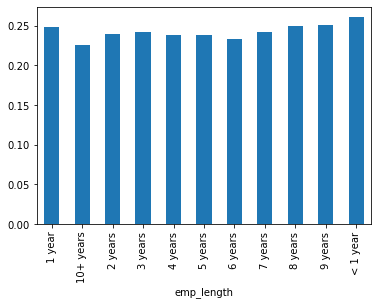

In [41]:
emp_co_fp_ratio.plot(kind='bar');

In [42]:
# not very informative, so we will drop
df = df.drop('emp_length', axis=1)

In [43]:
# What else has null?
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [44]:
feat_info('title')
df['title'].head(10)

The loan title provided by the borrower


0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
5         Debt consolidation
6           Home improvement
7       No More Credit Cards
8         Debt consolidation
9         Debt Consolidation
Name: title, dtype: object

In [45]:
feat_info('purpose')
df['purpose'].head(10)

A category provided by the borrower for the loan request. 


0              vacation
1    debt_consolidation
2           credit_card
3           credit_card
4           credit_card
5    debt_consolidation
6      home_improvement
7           credit_card
8    debt_consolidation
9    debt_consolidation
Name: purpose, dtype: object

In [46]:
# Seems like shared/duplicate info
# dropping the title column
df = df.drop('title', axis=1)

Let's look at the next big chunk of missing data

In [47]:
feat_info('mort_acc')
df['mort_acc'].head(10)

Number of mortgage accounts.


0    0.0
1    3.0
2    0.0
3    0.0
4    1.0
5    4.0
6    3.0
7    0.0
8    3.0
9    1.0
Name: mort_acc, dtype: float64

In [48]:
df['mort_acc'].value_counts()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
31.0         2
26.0         2
32.0         2
28.0         1
34.0         1
30.0         1
Name: mort_acc, dtype: int64

In [49]:
# Thoughts on dropping vs filling data:
# We could drop this feature, but it's around 10% of the data.
# However, since it's only around 10% of the data, 
# we should figure out a way to fill it in, if possible.

# Let's look for a column that we have all the info on (so, no missing values)
# which correlates well with our `mort_acc` feature.

In [50]:
df.corr()['mort_acc'].sort_values()

int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

Looks like `total_acc` correlates fine with `mort_acc`


In [51]:
# Average mort_acc value for each total_acc group
df.groupby('total_acc').mean()['mort_acc']

total_acc
2.0      0.000000
3.0      0.052023
4.0      0.066743
5.0      0.103289
6.0      0.151293
           ...   
124.0    1.000000
129.0    1.000000
135.0    3.000000
150.0    2.000000
151.0    0.000000
Name: mort_acc, Length: 118, dtype: float64

In [52]:
# We will basically do a fillna() with the average
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']

In [53]:
def fill_mort_acc_na(total_acc, mort_acc):
    """Checks for NaN. If NaN, returns the average
        mort_acc value relative to the total_acc group.

    Args:
        total_acc (pd.Series): Number of Credit Lines (per borrower)
        mort_acc (pd.Series): Number of Mortage Accounts
    """

    if np.isnan(mort_acc):
        # if NaN, lookup the average mort_acc for that group
        return total_acc_avg[total_acc]
    else:
        # If we already have the mort_acc, just return it
        return mort_acc

In [54]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc_na(
            x['total_acc'], x['mort_acc']), axis=1)

df['mort_acc']

0         0.000000
1         3.000000
2         0.000000
3         0.000000
4         1.000000
            ...   
396025    0.000000
396026    1.000000
396027    0.000000
396028    5.000000
396029    1.358013
Name: mort_acc, Length: 396030, dtype: float64

In [55]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
address                   0
loan_repaid               0
dtype: int64

In [56]:
# These two are a very small amount of data, so we can drop the rest of the NA values
df = df.dropna()

In [57]:
df.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
dtype: int64

### Done with Continuous variables, let's look at the rest!
### Categorical

In [58]:
# Let's go through all the non-numeric features
df.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

In [61]:
feat_info('term')
df['term'].value_counts()

The number of payments on the loan. Values are in months and can be either 36 or 60.


 36 months    301247
 60 months     93972
Name: term, dtype: int64

In [62]:
# To retain some of the relationship between 36months and 60months, 
# we will convert the strings to a numeric representation.
df['term'] = df['term'].apply(lambda term: int(term[:3]))

In [63]:
df['term'].value_counts()

36    301247
60     93972
Name: term, dtype: int64

In [64]:
# The 'grade' feature has its information represented in
# the 'sub_grade' feature, so we can drop 'grade'
df = df.drop('grade', axis=1)

In [65]:
# Dummy-ize 'sub_grade'
sub_grade_dummies = pd.get_dummies(df['sub_grade'],
                    drop_first=True)

# Concat our new features and remove the original column
df = pd.concat([df.drop('sub_grade', axis=1),
                sub_grade_dummies], axis=1)

In [66]:
df.select_dtypes(['object']).columns

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

In [69]:
# Dummy-ize ['verification_status', 'application_type', 
#           'initial_list_status', 'purpose']
#del sub_grade_dummies  # remove unused dataframe

dummies = pd.get_dummies(df[['verification_status', 'application_type',
                'initial_list_status', 'purpose']],
                drop_first=True)

# Concat our new features and remove the orginal columns
df = df.drop(['verification_status', 'application_type',
                'initial_list_status', 'purpose'],
                axis=1)
df = pd.concat([df,dummies], axis=1)

In [70]:
# Let's look at 'home_ownership' next
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [71]:
# We can dummy-ize this as well, but we will lump
# 'NONE' and 'ANY' into 'OTHER', because there are
# so few points.
df['home_ownership'] = df['home_ownership'].replace(
            ['NONE', 'ANY'], 'OTHER')

dummies = pd.get_dummies(df['home_ownership'], drop_first=True)
df = pd.concat([df.drop('home_ownership', axis=1), dummies], axis=1)

In [72]:
df.select_dtypes(['object']).columns

Index(['issue_d', 'loan_status', 'earliest_cr_line', 'address'], dtype='object')

In [73]:
# 'issue_d' is up next
feat_info('issue_d')

The month which the loan was funded


In [74]:
# This feature gives away a bit. If we don't give loans 
# to people who don't pay, we won't have this information
# before running the model.
df = df.drop('issue_d', axis=1)

In [76]:
# 'loan_status' is our target, so it would be dropped
# before training. But since we made 'loan_repaid',
# we can drop 'loan_status'
df = df.drop('loan_status', axis=1)

# 'earliest_cr_line' is up next.
feat_info('earliest_cr_line')
df['earliest_cr_line'].value_counts()

The month the borrower's earliest reported credit line was opened


Oct-2000    3013
Aug-2000    2930
Oct-2001    2890
Aug-2001    2879
Nov-2000    2729
            ... 
Nov-1953       1
Apr-1958       1
Jan-1957       1
Nov-1957       1
Nov-1955       1
Name: earliest_cr_line, Length: 684, dtype: int64

In [79]:
# We can extract the year and convert to numeric
df['earliest_cr_year'] = df['earliest_cr_line'].apply(
            lambda date: int(date[-4:]))
df = df.drop('earliest_cr_line', axis=1)  # drop original

In [82]:
df.select_dtypes('object').columns

Index(['loan_status', 'address'], dtype='object')

In [84]:
# address is our final column
#feat_info('address')
df['address'].value_counts

<bound method IndexOpsMixin.value_counts of 0            0174 Michelle Gateway\r\nMendozaberg, OK 22690
1         1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2         87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3                   823 Reid Ford\r\nDelacruzside, MA 00813
4                    679 Luna Roads\r\nGreggshire, VA 11650
                                ...                        
396025     12951 Williams Crossing\r\nJohnnyville, DC 30723
396026    0114 Fowler Field Suite 028\r\nRachelborough, ...
396027    953 Matthew Points Suite 414\r\nReedfort, NY 7...
396028    7843 Blake Freeway Apt. 229\r\nNew Michael, FL...
396029        787 Michelle Causeway\r\nBriannaton, AR 48052
Name: address, Length: 395219, dtype: object>

In [85]:
# We can extract just the zip code, similar to how
# we extracted just the year from 'earlist_cr_line'
df['zip_code'] = df['address'].apply(
                    lambda address: address[-5:])

In [86]:
# Then dummy-ize the zip
dummies = pd.get_dummies(df['zip_code'], drop_first=True)
# and concat after dropping original features
df = pd.concat([df.drop(['zip_code', 'address'], axis=1),
                dummies], axis=1)

In [88]:
# final column check
df.select_dtypes('object').columns

Index(['loan_status'], dtype='object')

### Train-Test-Split

In [90]:
X = df.drop('loan_repaid', axis=1).values
y = df['loan_repaid'].values

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=101)

In [93]:
scaler = MinMaxScaler()

In [94]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Creation

In [99]:
X_train.shape

(316175, 78)

In [100]:
"""
For this project I will be following the commonly relied-on
quote from Jeff Heaton,
author of Introduction to Neural Networks in Java,
 'the optimal size of the hidden layer is usually between the size of the input and size of the output layers'.
The hidden layers use the mean of the layer before and after.
"""

model = Sequential()

# input layer
model.add(Dense(78, activation='relu'))
model.add(Dropout(0.2))

# hidden layer 1
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer 2
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation='sigmoid'))

# Compilation step
model.compile(loss='binary_crossentropy', optimizer='adam')


In [101]:
model.fit(x=X_train,
          y=y_train,
          epochs=25,
          batch_size=256,
          validation_data=(X_test, y_test))

Train on 316175 samples, validate on 79044 samples
Epoch 1/25
316175/316175 [==============================] - 5s 16us/sample - loss: 0.2970 - val_loss: 0.2646
Epoch 2/25
316175/316175 [==============================] - 4s 14us/sample - loss: 0.2659 - val_loss: 0.2630
Epoch 3/25
316175/316175 [==============================] - 5s 15us/sample - loss: 0.2630 - val_loss: 0.2625
Epoch 4/25
316175/316175 [==============================] - 4s 14us/sample - loss: 0.2618 - val_loss: 0.2627
Epoch 5/25
316175/316175 [==============================] - 5s 14us/sample - loss: 0.2611 - val_loss: 0.2620
Epoch 6/25
316175/316175 [==============================] - 5s 15us/sample - loss: 0.2605 - val_loss: 0.2617
Epoch 7/25
316175/316175 [==============================] - 5s 15us/sample - loss: 0.2601 - val_loss: 0.2618
Epoch 8/25
316175/316175 [==============================] - 5s 16us/sample - loss: 0.2598 - val_loss: 0.2617
Epoch 9/25
316175/316175 [==============================] - 5s 15us/sample - 

## Evaluating Model Performance